In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from off_pol_eval_functions import * 
from matplotlib import cm
from scipy import interpolate
from mpl_toolkits.mplot3d import Axes3D

n = 5000
m = 10
d= 1
t_lo = -0.5
t_hi = 1.3
test_val = 0.4


## Data generation & configuration

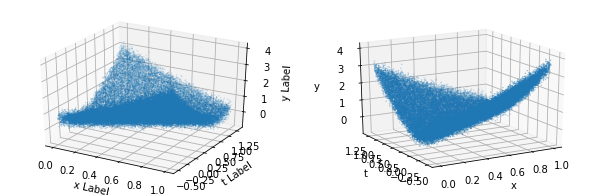

/Users/az/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/az/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0


AttributeError: 'float' object has no attribute 'log1p'

In [2]:
def generate_data_moving_parabolas(m,n, d, t_lo, t_hi): 
    xs = np.array(np.random.uniform(0,1,(n*m,d)))
    if t_lo < -10: 
        t_lo = -10
    if t_hi > 10: 
        t_hi = 10
    Ts = np.array(np.random.uniform(t_lo,t_hi, (n*m,d))) 
    Z = np.concatenate([xs,Ts], axis = 1)
    F = np.zeros([m*n,1])
    a = 2
    b = 7
    for i in np.arange(m*n): 
        F[i] = 2*pow(np.abs(xs[i] - Ts[i]),1.5)
#         F[i] = max(a*(np.abs(xs[i] - Ts[i])),b*(np.abs(xs[i] - Ts[i]))) + xs[i]
# Ensure outcomes are positive
    if min(F) < 0:
        F = F + abs(min(F))  
    Y = F + 0.2*np.random.randn(m*n,1)
    return { 'y': Y, 'z': Z, 'f': F , 'x': xs}

def oracle_evaluation(**params): 
    # does oracle evaluation include randomness? 
    X = params['x_samp']; tau = params['tau']
    return 2*pow(np.abs(X - tau),1.5) + 0.2*np.random.randn(params['n'],1)

data = generate_data_moving_parabolas(m,n, d, t_lo, t_hi)
sub_params = { 'n': n, 'y': data['y'],'f': data['f'], 'x': data['x'],'d': d, 'T': data['z'][:,d], 'z': data['z'], 'm': m, 'h': 0.001, 'Q': unif_Q , 't_lo': t_lo ,'t_hi': t_hi  }

# output = open('data_exp' + str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")) + '.pkl', 'wb')
# pickle.dump(sub_params, output)
# output.close()

sub_params['Q'] = unif_Q 
sub_params['sampling'] = "uniform"
plot_surface(**sub_params)

# Set Kernel Function (and integral) 
sub_params['kernel_func'] = epanechnikov_kernel
sub_params['kernel_int_func'] = epanechnikov_int
sub_params['threshold'] = 0.01
# Set Oracle Function Structure (known or interpolated? )
sub_params['oracle_func'] = oracle_evaluation
#Set data generation scheme (grid of values or uniformly sampled?)
sub_params['data_gen'] = "uniform"

# sub_params['oracle_func'] =  evaluate_oracle_interpolated_outcomes
spl_x = sub_params['z'][:,0]
spl_t = sub_params['z'][:,1]
# f is positive
splined_f_tck = interpolate.bisplrep(spl_x,spl_t, sub_params['f'])
sub_params['spline'] = splined_f_tck

h = bandwidth_selection(200, 10, **sub_params)
print h

In [ ]:
def generate_dataset(m,n,d,t_lo,t_hi, sampling, Q ): 
    data = generate_data_moving_parabolas(m,n, d, t_lo, t_hi)
    sub_params = { 'n': n, 'y': data['y'],'f': data['f'], 'x': data['x'],'d': d, 'T': data['z'][:,d], 'z': data['z'], 'm': m, 'h': 0.001, 'Q': unif_Q , 't_lo': t_lo ,'t_hi': t_hi  }
    sub_params['x_samp'] = data['x']
    sub_params['T_samp'] = sub_params['T']
    data['y_samp'] = data['y']
    sub_params['Q'] = Q 
    sub_params['sampling'] = sampling
    # Scaling ought to be different for the unbounded case (closer to 0.5)
    sub_params['h'] = 0.1
    # Set Kernel Function (and integral) 
    sub_params['kernel_func'] = epanechnikov_kernel
    sub_params['kernel_int_func'] = epanechnikov_int
    sub_params['threshold'] = 0.01
    sub_params['n_bins'] = 10 
    # Set Oracle Function Structure (known or interpolated? )
    sub_params['oracle_func'] = oracle_evaluation
    #Set data generation scheme (grid of values or uniformly sampled?)
    sub_params['data_gen'] = "uniform"
    return sub_params

# Testing constant off-policy evaluation

In [ ]:

def off_policy_evaluation(**params):
    """
    Takes in a choice of kernel and dictionary of parameters and data required for evaluation
    tau is a vector of treatment values (assumed given)
    If y_samp, T_samp is present, use that instead. 
    """
    THRESH = 0.015
    y_out = params['y']; x = params['x']; h = params['h'];Q = params['Q']; n = params['n']; t_lo = params['t_lo'];  t_hi = params['t_hi']
    kernel = params['kernel_func'];kernel_int =  params['kernel_int_func']
    if ('y_samp' in params.keys()):
        y_out = params['y_samp']
    if ('T_samp' in params.keys()): 
        T = params['T_samp']
    else: 
        T = params['T']
    if ('x_samp' in params.keys()):
        x = params['x_samp']
    loss = 0
    tau = params['tau']
    clip_tau = np.clip(tau, t_lo, t_hi)
    Qs = np.zeros(n)
    for i in np.arange(n): 
        Q_i = Q(x[i], T[i], t_lo, t_hi)
        if (abs(clip_tau[i] - t_lo) <= h):
            alpha = kernel_int((t_lo-clip_tau[i])/h, 1)
            if alpha < 0.5: 
                print alpha
        elif (abs(clip_tau[i] - t_hi) <= h):
            alpha = kernel_int(-1,  (t_hi - clip_tau[i])/h )
            if alpha < 0.5: 
                print alpha
        else:
            alpha = 1
        Qs[i] = kernel( (clip_tau[i] - T[i])/h )*h/Q_i
        loss += kernel( (clip_tau[i] - T[i])/h )*1.0 * y_out[i]/max(Q_i,THRESH) * 1.0/alpha
    norm_sum = sum(Qs)    
    return loss/(norm_sum*1.0*h*n)

n_sub = 200
samp_params = evaluate_subsample( n_sub, evaluation = False, cross_val = False, **sub_params )
samp_params['tau'] = 0.5*np.ones(n)
off_policy_evaluation(**samp_params)

## Consistency of policy evaluation wrt n 

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor

n_trials = 50
n_treatments = 10
n_spacing = 20
n_0 = 5
sub_params['n_bins'] = 10
n_max = 300
sub_params['h'] = 0.1
sub_params['sampling'] = "normal"
sub_params['Q'] = norm_Q

# sampling = "uniform"
# Q = unif_Q

def comp_policy(t, x): 
#     return t*x
    if x < t: 
        return 0
    if x > t: 
        return 0.3

sub_params['threshold'] = 0.1
def direct_method(**subsamples_pm): 
    X_train = np.hstack([subsamples_pm['x_samp'], subsamples_pm['T_samp']])
    lin_regressor = LinearRegression()
    poly = PolynomialFeatures(3)
    X_transform = poly.fit_transform(X_train)
    lin_regressor.fit(X_transform,subsamples_pm['y_samp']) 
    # get the predictions
    X_test =np.hstack([subsamples_pm['x_samp'], subsamples_pm['tau']]) # evaluate predictor at tau and average 
    y_preds = lin_regressor.predict(poly.fit_transform(X_test))
    return np.mean(y_preds)

def direct_method(**subsamples_pm): 
    X_train = np.hstack([subsamples_pm['x_samp'], subsamples_pm['T_samp']])
    lin_regressor = LinearRegression()
    poly = PolynomialFeatures(3)
    X_transform = poly.fit_transform(X_train)
    lin_regressor.fit(X_transform,subsamples_pm['y_samp']) 
    # get the predictions
    X_test =np.hstack([subsamples_pm['x_samp'], subsamples_pm['tau']]) # evaluate predictor at tau and average 
    y_preds = lin_regressor.predict(poly.fit_transform(X_test))
    return np.mean(y_preds)

def direct_method_rf(**subsamples_pm): 
    X_train = np.hstack([subsamples_pm['x_samp'], subsamples_pm['T_samp']])
    clf = RandomForestRegressor(n_estimators=10)
    clf = clf.fit(X_train,y=subsamples_pm['y_samp'])
    # get the predictions
    X_test =np.hstack([subsamples_pm['x_samp'], subsamples_pm['tau']]) # evaluate predictor at tau and average 
    y_preds = clf.predict( X_test )
    return np.mean(y_preds)


def off_pol_eval_comp_test(n_max, n_trials, n_treatments, n_spacing, n_0, t, **sub_params):
    '''
    Test for a single value of t 
    '''
    n = sub_params['n']; m = sub_params['m']
    off_pol_evals = np.zeros([n_spacing, n_trials])
    oracle_evals = np.zeros([n_spacing, n_trials])
    discrete_off_pol_evals = np.zeros([n_spacing, n_trials])
    dm_evals = np.zeros([n_spacing, n_trials]); dm_rf_evals = np.zeros([n_spacing, n_trials])
    oracle_func = sub_params['oracle_func']
    splined_f_tck = sub_params['spline']
    h_orig = sub_params['h']
    for i, n_sub in enumerate(np.linspace(n_0, n_max, n_spacing)): 
        # sub_params['h'] = h_orig * (np.power(n_sub,0.2))/np.power(n_0,0.2)
        n_rnd = int(np.floor(n_sub))
        print "testing with n = " + str(n_rnd)
        for k in np.arange(n_trials):
            # Use evaluate subsample because that samples appropriately 
            subsamples_pm = evaluate_subsample( n_rnd, evaluation = False, cross_val = False, **sub_params )
#             subsamples_pm = generate_dataset(n_rnd,1,d,t_lo,t_hi, sampling, Q )
            subsamples_pm['tau'] = t*subsamples_pm['x_samp']
#             subsamples_pm['tau'] = subsamples_pm['x_samp']
            #np.asarray( [ comp_policy(t,x) for x in subsamples_pm['x_samp'] ] ).flatten()
            oracle_evals[i, k] = np.mean(oracle_func(**subsamples_pm))
            # oracle_evals[t_ind, i, k] = np.mean(evaluate_oracle_interpolated_outcomes(splined_f_tck, m,n_rnd, subsamples_pm['f'], t_lo, t_hi, subsamples_pm['tau'], subsamples_pm['x_samp']))
            off_pol_evals[i, k] = off_policy_evaluation(**subsamples_pm)
            discrete_off_pol_evals[i, k] = off_pol_disc_evaluation(discretize_tau_policy , **subsamples_pm)
            dm_evals[i,k] = direct_method(**subsamples_pm)
            dm_rf_evals[i,k] = direct_method_rf(**subsamples_pm)
            
    off_pol_evals.dump( str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")) + 'off_pol_vals_for_consistency-norm.np')
    oracle_evals.dump(str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")) + 'off_pol_oracles_for_consistency-norm.np')
    discrete_off_pol_evals.dump(str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")) + 'discrete_pol_evals_for_consistency-norm.np')
    return [oracle_evals, off_pol_evals, discrete_off_pol_evals, dm_evals, dm_rf_evals]

t_lo = -0.5
t_hi = 1.3
[oracle_evals, off_pol_evals, off_pol_disc_evals, dm_evals, dm_rf_evals] = off_pol_eval_comp_test(n_max, n_trials, n_treatments, n_spacing, n_0, 1, **sub_params)


In [ ]:
def off_pol_estimator(**params): 

    THRESH = params['threshold']
    y_out = params['y']; x = params['x']; h = params['h'];Q = params['Q']; n = params['n']; t_lo = params['t_lo'];  t_hi = params['t_hi']
    kernel = params['kernel_func'];kernel_int =  params['kernel_int_func']
    if ('y_samp' in params.keys()):
        y_out = params['y_samp']
    if ('T_samp' in params.keys()): 
        T = params['T_samp']
    else: 
        T = params['T']
    if ('x_samp' in params.keys()):
        x = params['x_samp']

    BMI_IND = params.get('BMI_IND') # propensity score for warfarin data evaluations 
    if (params.get('DATA_TYPE') == 'warfarin'): 
        x = params['x'][:,BMI_IND]

    loss = 0
    tau = params['tau']
    clip_tau = np.clip(tau, t_lo, t_hi)
    Qs = np.zeros(n)
    for i in np.arange(n): 
        Q_i = Q(x[i], T[i], t_lo, t_hi)
        if (abs(clip_tau[i] - t_lo) <= h):
            alpha = kernel_int((t_lo-clip_tau[i])/h, 1)
        elif (abs(clip_tau[i] - t_hi) <= h):
            alpha = kernel_int(-1,  (t_hi - clip_tau[i])/h )
        else:
            alpha = 1
        Qs[i] = (1.0/h)*kernel( (clip_tau[i] - T[i])/h )/max(Q_i,THRESH)
        loss += kernel( (clip_tau[i] - T[i])/h )*1.0 * y_out[i]/max(Q_i,THRESH) * 1.0/alpha
    norm_sum = np.mean(np.maximum(Qs,THRESH*np.ones(n)))
    print loss 
    print norm_sum 
    print loss/(norm_sum*1.0*h*n)
    return [loss, norm_sum]

subsamples_pm = evaluate_subsample( 15, evaluation = False, cross_val = False, **sub_params )
subsamples_pm['tau'] = subsamples_pm['x_samp']
off_pol_estimator(**subsamples_pm)


# Figure 1 

In [ ]:
mean_off_pol_vals = np.nanmean(off_pol_evals, axis = 1)
mean_oracle_vals = np.mean(oracle_evals,axis=1)
sds_off_pol = np.std(off_pol_evals, axis = 1)
sds_oracle = np.std(oracle_evals, axis = 1)
mean_off_pol_disc_evals = np.mean(off_pol_disc_evals,axis=1)
sds_off_pol_disc = np.std(off_pol_disc_evals, axis = 1)
mean_off_pol_dm_vals = np.mean(dm_evals,axis=1)
sds_off_pol_dm = np.std(dm_evals, axis = 1)

mean_off_pol_dm_rf_vals = np.mean(dm_rf_evals,axis=1)
sds_off_pol_dm_rf = np.std(dm_rf_evals, axis = 1)

ns = np.linspace(n_0, n_max, n_spacing)

plt.figure(figsize=(6,2.5))
ax = plt.subplot(111)
plt.style.use('seaborn-notebook')

error_1 = 1.96*sds_off_pol/np.sqrt(n_trials)
error_2 = 1.96*sds_oracle/np.sqrt(n_trials)
error_3 = 1.96*sds_off_pol_disc/np.sqrt(n_trials)
error_4 = 1.96*sds_off_pol_dm/np.sqrt(n_trials)
error_5 = 1.96*sds_off_pol_dm_rf/np.sqrt(n_trials)


# ax = fig.add_subplot(1,1,1) 
ax.tick_params(labeltop='off', labelright='off')

plt.fill_between(ns, mean_oracle_vals-error_2, mean_oracle_vals+error_2, alpha=0.4, edgecolor='blue', facecolor='blue')
plt.scatter( ns , mean_oracle_vals, c = "blue", label="true outcomes",marker='+',s=35)
plt.scatter(ns, mean_off_pol_disc_evals, c = "green", label="discretized OPE",s=35)
plt.fill_between(ns, mean_off_pol_disc_evals-error_3, mean_off_pol_disc_evals+error_3, alpha=0.4, edgecolor='g', facecolor='g')
plt.scatter(ns, mean_off_pol_vals[:], c = "red", label="continuous OPE",marker='v',s=35)
plt.fill_between(ns, mean_off_pol_vals-error_1, mean_off_pol_vals+error_1, alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.fill_between(ns, mean_off_pol_dm_vals-error_4, mean_off_pol_dm_vals+error_4, alpha=0.35, edgecolor='purple', facecolor='purple')
plt.scatter(ns, mean_off_pol_dm_vals[:], c = "purple", label="DM Poly",marker='*',s=35)
plt.fill_between(ns, mean_off_pol_dm_rf_vals-error_5, mean_off_pol_dm_rf_vals+error_5, alpha=0.35, edgecolor='brown', facecolor='brown')
plt.scatter(ns, mean_off_pol_dm_rf_vals[:], c = "brown", label="DM RF",marker='o',s=35)

plt.title("")
plt.ylabel("estimated policy values")
plt.xlabel("number of samples in sampled dataset")

plt.legend(prop={'size':8}, )
max_y = .12
# plt.yticks(np.arange(0, max_y+0.1, 0.3))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.ylim((-0.02,.2))
# plt.xlim((10,300))
plt.yticks(np.arange(0, max_y+0.02, 0.04))
ax.legend(bbox_to_anchor=(1, 1.3),ncol=2)


plt.show()

In [ ]:
print mean_off_pol_dm_rf_vals[-1]

print mean_off_pol_vals[-1]

## Test for multiple values of beta

In [ ]:
t_lo = -0.5
t_hi = 1.3
beta_0 = -0.5
beta_hi = 1.3
[full_oracle_evals, full_off_pol_evals, full_off_pol_disc_evals] = off_pol_eval_linear_test( n_max, beta_0, beta_hi, n_trials, n_treatments, n_spacing, n_0, **sub_params)

## Plot full surface with errors 

In [ ]:
plot_off_pol_evals(off_pol_evals, oracle_evals, off_pol_disc_evals, n_0, n_max, n_trials, n_treatments, n_spacing, t_lo, t_hi, "treatment values", "Constant Policy Evaluations vs true counterfactual policy evaluations (truncated y)", truncate_y = 1  )


## Testing of a nontrivial policy

In [ ]:
plot_off_pol_evals(off_pol_evals, oracle_evals, off_pol_disc_evals, n_0, n_max, n_trials, n_treatments, n_spacing, t_lo, t_hi, "treatment values", "Constant Policy Evaluations vs true counterfactual policy evaluations (truncated y)", truncate_y = 3  )


In [ ]:
n_trials = 10
n_treatments = 20
n_spacing = 3
n_0 = 100
sub_params['n_bins'] = 10
n_max = 500
sub_params['h'] = 0.1
sub_params['sampling'] = "normal"
import sys

t_lo = -0.5
t_hi = 1.5
[oracle_evals, off_pol_evals, off_pol_disc_evals] = off_pol_eval_cons_test(n_max, n_trials, n_treatments, n_spacing, n_0, t_lo, t_hi, check_alpha = True, **sub_params)
plot_off_pol_evals(off_pol_evals, oracle_evals, off_pol_disc_evals, n_0, n_max, n_trials, n_treatments, n_spacing, t_lo, t_hi, "treatment values", "Constant Policy Evaluations vs true counterfactual policy evaluations (truncated y)", truncate_y = 3  )


## Testing 

In [ ]:
def off_pol_disc_evaluation(policy, **params):
    THRESH = params['threshold']
    y_out = params['y']; x = params['x_samp']; h = params['h']; Q = params['Q']; n = params['n']; t_lo = params['t_lo']; t_hi = params['t_hi']
    n_bins = params['n_bins']
    if ('y_samp' in params.keys()):
        y_out = params['y_samp'].flatten()
    if ('T_samp' in params.keys()):
        T = params['T_samp'].flatten()
    else:
        T = params['T'].flatten()

    BMI_IND = params.get('BMI_IND') # propensity score for warfarin data evaluations 
    if (params.get('DATA_TYPE') == 'warfarin'): 
        x = params['x'][:,BMI_IND]

    t_lo = min(T)
    t_hi = max(T)
    bin_width = t_hi-t_lo
    bins = np.linspace(t_lo, t_hi, n_bins)
    T_binned = np.digitize(T, bins, right = True).flatten()
    bin_means = [T[T_binned == i].mean() for i in range(1, len(bins))]

    loss = 0
    tau_vec = policy(**params).flatten()
    #! FIXME need to establish whether policy returns discrete bins or means
    treatment_overlap = np.where(np.equal(tau_vec.flatten(), T_binned))[0]
    n_overlap = len(treatment_overlap)
    Qs = np.zeros(n_overlap)
    i=0
    for ind in treatment_overlap:
        Q_i = Q(x[ind], bin_means[T_binned[ind]-1], t_lo, t_hi) * bin_width*1.0/n_bins # BUG FIX: this is going to have to be integrated against 
        Qs[i] = 1.0/max(Q_i,THRESH)
        
        loss += y_out[ind]/max(Q_i,THRESH)
        i+=1 
    
    norm_sum = np.mean(np.maximum(Qs,THRESH*np.ones(n_overlap)))
    if n_overlap == 0:
        print "no overlap"
        return 0
    print norm_sum
    return loss/(1.0*n*norm_sum)


subsamples_pm = evaluate_subsample( 100, evaluation = False, cross_val = False, **sub_params )
subsamples_pm['tau'] = 0.4*subsamples_pm['x_samp'] 

print off_pol_disc_evaluation(discretize_tau_policy , **subsamples_pm)

## Off-policy evaluation for linear treatment policy

# Figure 2

In [ ]:
def off_pol_eval_linear_test( n_max, beta_0, beta_hi, n_trials, n_treatments, n_spacing, n_0, **sub_params):
    '''
    '''
    treatment_space = np.linspace(beta_0, beta_hi, n_treatments)
    off_pol_evals = np.zeros([n_treatments, n_spacing, n_trials])
    oracle_evals = np.zeros([n_treatments, n_spacing, n_trials])
    discrete_off_pol_evals = np.zeros([n_treatments, n_spacing, n_trials])
    dm_evals = np.zeros([n_treatments, n_spacing, n_trials])
    dm_rf_evals = np.zeros([n_treatments, n_spacing, n_trials])
    t_lo = sub_params['t_lo']; t_hi = sub_params['t_hi']; spl_x = sub_params['z'][:,0]; spl_t = sub_params['z'][:,1]
    # f is positive
    splined_f_tck = interpolate.bisplrep(spl_x,spl_t, sub_params['f'])
    sub_params['spline'] = splined_f_tck
    oracle_func = sub_params['oracle_func']
    n = sub_params['n']; m = sub_params['m']; h_orig = sub_params['h']
    for i, n_sub in enumerate(np.linspace(n_0, n_max, n_spacing)): 
        n_rnd = int(np.floor(n_sub))
        
        print "testing n = " + str(n_rnd)
        for k in np.arange(n_trials):
            for beta_ind, beta in enumerate(treatment_space):
                subsamples_pm = evaluate_subsample( n_rnd, evaluation = False, cross_val = False, **sub_params )
                tau = np.clip(np.dot( subsamples_pm['x_samp'], beta ) , t_lo, t_hi)
                subsamples_pm['h'] = h_orig * (np.power(n_sub,0.2))/np.power(n,0.2)
                subsamples_pm['tau'] = tau
                oracle_evals[beta_ind, i, k] = np.mean(oracle_func(**subsamples_pm))
                # oracle_evals[beta_ind, i, k] = np.mean(evaluate_oracle_interpolated_outcomes(splined_f_tck,m,n_rnd, subsamples_pm['f'], beta_0, beta_hi, tau, subsamples_pm['x_samp']))
                # off_pol_evals[beta_ind, i, k] = off_policy_evaluation(**subsamples_pm)
                off_pol_evals[beta_ind, i, k] = off_policy_evaluation(**subsamples_pm)
                discrete_off_pol_evals[beta_ind, i, k] = off_pol_disc_evaluation(discretize_tau_policy , **subsamples_pm)
                dm_evals[beta_ind, i,k] = direct_method(**subsamples_pm)
                dm_rf_evals[beta_ind, i,k] = direct_method_rf(**subsamples_pm)
#     off_pol_evals.dump( str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")) + 'off_pol_linear_vals.np')
#     oracle_evals.dump(str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")) + 'off_pol_linear_oracles.np')
    return [oracle_evals, off_pol_evals, discrete_off_pol_evals, dm_evals, dm_rf_evals]

def plot_off_pol_evals_gen(off_pol_evals, oracle_evals, off_pol_disc_evals, dm_evals, dm_rf_evals, n_0, n, n_trials, n_treatments, n_spacing, t_lo, t_hi, x_label, title_stem, y_min = False, y_max = False):
    mean_off_pol_vals = np.mean(off_pol_evals, axis = 2)
    mean_oracle_vals = np.mean(oracle_evals,axis=2)
    sds_off_pol = np.std(off_pol_evals, axis = 2); sds_oracle = np.std(oracle_evals, axis = 2)
    mean_off_pol_disc_evals = np.mean(off_pol_disc_evals,axis=2); sds_off_pol_disc = np.std(off_pol_disc_evals, axis = 2)
    mean_off_pol_dm_vals = np.mean(dm_evals,axis=2); sds_off_pol_dm = np.std(dm_evals, axis = 2)
    
    mean_off_pol_dm_rf_vals = np.mean(dm_rf_evals,axis=2)
    sds_off_pol_dm_rf = np.std(dm_rf_evals, axis = 2); ts = np.linspace(t_lo, t_hi, n_treatments); ns = np.linspace(n_0, n, n_spacing)
    
    for i in np.arange(n_spacing):
        plt.style.use('seaborn-notebook')
        plt.figure(figsize=(7,2.75))
        ax = plt.subplot(111)
        error_1 = 1.96*sds_off_pol[:,i]/np.sqrt(n_trials)
        error_2 = 1.96*sds_oracle[:,i]/np.sqrt(n_trials)
        error_3 = 1.96*sds_off_pol_disc[:,i]/np.sqrt(n_trials)
        error_4 = 1.96*sds_off_pol_dm[:,i]/np.sqrt(n_trials)
        error_5 = 1.96*sds_off_pol_dm_rf[:,i]/np.sqrt(n_trials)
        
        plt.fill_between(ts, mean_oracle_vals[:,i]-error_2, mean_oracle_vals[:,i]+error_2, edgecolor='blue', facecolor='blue',alpha=0.3)
        plt.plot(ts, mean_oracle_vals[:,i], c = "blue", markersize = 10 ,label="oracle values",alpha=0.4)
        
        plt.plot(ts, mean_off_pol_disc_evals[:,i], c = "green", marker='s', label='naively discretized OPE', markersize = 7)
        plt.fill_between(ts, mean_off_pol_disc_evals[:,i]-error_3, mean_off_pol_disc_evals[:,i]+error_3, alpha=0.4, edgecolor='g', facecolor='g')
        
        plt.fill_between(ts, mean_off_pol_vals[:,i]-error_1, mean_off_pol_vals[:,i]+error_1, alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
        plt.plot(ts, mean_off_pol_vals[:,i], c = "red", marker='v', label='continuous OPE', markersize = 10 )
        
        plt.fill_between(ts, mean_off_pol_dm_vals[:,i]-error_4, mean_off_pol_dm_vals[:,i]+error_4, alpha=0.35, edgecolor='purple', facecolor='purple')
        plt.plot(ts, mean_off_pol_dm_vals[:,i], c = "purple", marker='*', label='DM poly', markersize = 10)
        
        plt.fill_between(ts, mean_off_pol_dm_rf_vals[:,i]-error_5, mean_off_pol_dm_rf_vals[:,i]+error_5, alpha=0.35, edgecolor='brown', facecolor='brown')
        plt.plot(ts, mean_off_pol_dm_rf_vals[:,i], c = "brown", marker='o', label='DM RF', markersize = 8)
    #     plt.ylim( (0, 10) )
        print ns[i]
#         plt.title(title_stem+ " with n = " + str(ns[i]))
        plt.ylabel("Regret compared to true policy value")
        plt.xlabel(x_label)
#         if y_min!=False: 
#         plt.ylim(y_min,y_max)
#         plt.yticks(np.arange(y_min, y_max, 0.1))
        plt.xlim(0,1.3)
        
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        # Only show ticks on the left and bottom spines
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        
        plt.legend(prop={'size':8})
        ax.legend(bbox_to_anchor=(.3, .95),ncol=2)
        plt.show()

In [ ]:
beta_hi = t_hi/max(sub_params['x'])
n_trials = 50
sub_params['n_bins'] = 10
n_treatments = 20
n_spacing = 3
n_0 = 100
n_max = 500
sub_params['h'] = 0.1

sub_params['Q'] = norm_Q
sub_params['sampling']='normal'


[lin_oracle_evals, lin_off_pol_evals, off_pol_disc_evals, dm_evals, dm_rf_evals] = off_pol_eval_linear_test( n_max, 0, beta_hi, n_trials, n_treatments, n_spacing, n_0, check_alpha = True, **sub_params)
lin_off_pol_evals.dump( str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")) + 'off_pol_linear_vals_normal.np')
oracle_evals.dump(str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")) + 'off_pol_linear_oracles_normal.np')
off_pol_disc_evals.dump(str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")) + 'disc_off_pol_linear_normal.np')

plot_off_pol_evals_gen(lin_off_pol_evals, lin_oracle_evals, off_pol_disc_evals, dm_evals, dm_rf_evals, n_0, n_max, n_trials, n_treatments, n_spacing, 0, beta_hi, "beta values", "Linear Policy Evaluations vs true counterfactual policy evaluations")

In [ ]:
plot_off_pol_evals_gen(lin_off_pol_evals, lin_oracle_evals, off_pol_disc_evals, dm_evals, dm_rf_evals, n_0, n_max, n_trials, n_treatments, n_spacing, 0, beta_hi, "beta values", "Linear Policy Evaluations vs true counterfactual policy evaluations", y_min=-0.3, y_max =0.2)

## plots of regret

In [ ]:
print np.mean(np.abs(lin_off_pol_evals-lin_oracle_evals)[:,1,:])
print np.mean(np.abs(lin_oracle_evals-lin_oracle_evals)[:,1,:])
print np.mean(np.abs(off_pol_disc_evals-lin_oracle_evals)[:,1,:])
print np.mean(np.abs(dm_rf_evals-lin_oracle_evals)[:,1,:])


In [ ]:
plot_off_pol_evals_gen(lin_off_pol_evals-lin_oracle_evals, lin_oracle_evals-lin_oracle_evals, off_pol_disc_evals-lin_oracle_evals, dm_evals-lin_oracle_evals, dm_rf_evals-lin_oracle_evals, n_0, n_max, n_trials, n_treatments, n_spacing, 0, beta_hi, "beta values", "Linear Policy Evaluations vs true counterfactual policy evaluations", y_min=-0.3, y_max =0.2)

In [ ]:

sub_params['Q'] = unif_Q
sub_params['sampling']='uniform'

[lin_oracle_evals, lin_off_pol_evals, off_pol_disc_evals] = off_pol_eval_linear_test( n_max, 0, beta_hi, n_trials, n_treatments, n_spacing, n_0, check_alpha = True, **sub_params)
plot_off_pol_evals(lin_off_pol_evals, lin_oracle_evals, off_pol_disc_evals, n_0, n_max, n_trials, n_treatments, n_spacing, 0, beta_hi, "beta values", "Linear Policy Evaluations vs true counterfactual policy evaluations")
        

In [ ]:
def plot_off_pol_evals(off_pol_evals, oracle_evals, off_pol_disc_evals, n_0, n, n_trials, n_treatments, n_spacing, t_lo, t_hi, x_label, title_stem, truncate_y = False):
    mean_off_pol_vals = np.mean(off_pol_evals, axis = 2)
    mean_oracle_vals = np.mean(oracle_evals,axis=2)
    sds_off_pol = np.std(off_pol_evals, axis = 2)
    sds_oracle = np.std(oracle_evals, axis = 2)
    mean_off_pol_disc_evals = np.mean(off_pol_disc_evals,axis=2)
    sds_off_pol_disc = np.std(off_pol_disc_evals, axis = 2)

    ts = np.linspace(t_lo, t_hi, n_treatments)

    ns = np.linspace(n_0, n, n_spacing)
    for i in np.arange(n_spacing):
        plt.figure(i+1)
        plt.style.use('seaborn-notebook')
        plt.figure(figsize=(4.5,2.2))
        error_1 = 1.96*sds_off_pol[:,i]/np.sqrt(n_trials)
        error_2 = 1.96*sds_oracle[:,i]/np.sqrt(n_trials)
        error_3 = 1.96*sds_off_pol_disc[:,i]/np.sqrt(n_trials)

        
        plt.fill_between(ts, mean_oracle_vals[:,i]-error_2, mean_oracle_vals[:,i]+error_2, edgecolor='blue', facecolor='blue',alpha=0.1)
        plt.plot(ts, mean_oracle_vals[:,i], c = "blue", marker='s', markersize = 1 ,label="oracle values")
        
        plt.scatter(ts, mean_off_pol_disc_evals[:,i], c = "green", label='naively discretized OPE')
        plt.fill_between(ts, mean_off_pol_disc_evals[:,i]-error_3, mean_off_pol_disc_evals[:,i]+error_3, alpha=0.4, edgecolor='g', facecolor='g')
        
        plt.fill_between(ts, mean_off_pol_vals[:,i]-error_1, mean_off_pol_vals[:,i]+error_1, alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
        plt.scatter(ts, mean_off_pol_vals[:,i], c = "red", marker='v', label='continuous OPE')
    #     plt.ylim( (0, 10) )
        print ns[i]
#         plt.title(title_stem+ " with n = " + str(ns[i]))
        plt.ylabel("outcome Y")
        plt.xlabel(x_label)
        if truncate_y: 
            plt.ylim((0,truncate_y))
        plt.yticks(np.arange(0, 1+0.1, 0.3))
        plt.xlim(0,1.3)
#         plt.legend(prop={'size':8})
        plt.show()

plot_off_pol_evals(lin_off_pol_evals, lin_oracle_evals, off_pol_disc_evals, n_0, n_max, n_trials, n_treatments, n_spacing, 0, beta_hi, "beta values", "Linear Policy Evaluations vs true counterfactual policy evaluations", truncate_y=1)


In [ ]:
# print np.abs(np.mean(off_pol_evals,axis = 2)  - np.mean(oracle_evals, axis =2 ))
print "Percent errors: "
print (np.abs(np.mean(off_pol_evals,axis = 2)  - np.mean(oracle_evals, axis =2 ))) / np.mean(oracle_evals, axis =2 ) 

## testing out of sample convergence 

In [ ]:
sub_params['h']

In [ ]:
sub_params['Q'] = norm_Q
sub_params['sampling']='normal'
sub_params['h'] = 0.1
def off_pol_opt_test(n_max, n_trials, n_spacing, n_0, t_lo_sub,t_hi_sub, **sub_params):
    
    n = sub_params['n']; m = sub_params['m']; t_lo = t_lo_sub; t_hi = t_hi_sub
    d = sub_params['d']
    n_space = np.linspace(n_0, n_max, n_spacing)
    best_beta = np.zeros([len(n_space),n_trials])
    best_oracle_beta = np.zeros([len(n_space),n_trials])
    OOS_OPE = np.zeros([len(n_space),n_trials])
    OOS_oracle = np.zeros([len(n_space),n_trials])
    # discrete_off_pol_evals = np.zeros([n_treatments, n_spacing, n_trials])
    oracle_func = sub_params['oracle_func']
    h_orig = 0.1
    n_restarts = 5
    TEST_N = 250
    TEST_SET = evaluate_subsample( 250, evaluation = False, cross_val = False, **sub_params )
    def eval_oracle_tau_evaluation(beta, *args):
        params = dict(args[0])
        t_lo = params['t_lo']
        t_hi = params['t_hi']
        tau_candidate = beta*params['x_samp']
        #!FIXME graceful handling of loss function of y_i
        params['tau'] = tau_candidate
        return np.mean(oracle_func(**params)) 
    
    for i, n_sub in enumerate(np.linspace(n_0, n_max, n_spacing)): 
        # sub_params['h'] = h_orig * (np.power(n_sub,0.2))/np.power(n_0,0.2)
        n_rnd = int(np.floor(n_sub))
        sub_params['h'] = h_orig * (np.power(n_0,0.2))/np.power(n_sub,0.2)
        print "testing with n = " + str(n_rnd)
        for k in np.arange(n_trials):
            subsamples_pm = evaluate_subsample( n_rnd, evaluation = False, cross_val = False, **sub_params )
            samp_params = subsamples_pm
            # oracle_evals[t_ind, i, k] = np.mean(evaluate_oracle_interpolated_outcomes(splined_f_tck, m,n_rnd, subsamples_pm['f'], t_lo, t_hi, subsamples_pm['tau'], subsamples_pm['x_samp']))
            ### Compute best betas with random restarts 
            oracle_betas = np.zeros([n_restarts, d]);eval_vals = np.zeros([n_restarts, d]);emp_betas = np.zeros([n_restarts, d]);emp_eval_vals = np.zeros([n_restarts, d])
            for i_restart in np.arange(n_restarts):
                beta_d = np.random.uniform() 
                res = minimize(lin_off_policy_loss_evaluation, x0 = beta_d, jac = off_pol_epan_lin_grad, bounds = ((t_lo/max(samp_params['x_samp']), t_hi/max(samp_params['x_samp']) ),) , args=samp_params.items() )
                emp_betas[i_restart] = res.x; emp_eval_vals[i_restart] = res.fun

                oracle_res = minimize(eval_oracle_tau_evaluation, x0 = beta_d, bounds = ((0, 1.0/np.mean(samp_params['x']) ),) , args=samp_params.items() )
                oracle_betas[i_restart] = oracle_res.x; eval_vals[i_restart] = oracle_res.fun  

                # get best beta value from random restarts
            best_ind = np.argmin(emp_eval_vals)
            best_beta[i,k] =  emp_betas[best_ind,:]
            
            best_oracle_ind = np.argmin(eval_vals)
            best_oracle_beta[i,k] =  oracle_betas[best_oracle_ind,:]
            TEST_SET['tau'] = best_beta[i,k] * TEST_SET['x_samp']
            OOS_OPE[i,k] = off_policy_evaluation(**TEST_SET)
            OOS_oracle[i,k] = np.mean(oracle_func(**TEST_SET))

    return [best_beta, best_oracle_beta, OOS_OPE, OOS_oracle]
n_spacing = 10
n_trials = 10
t_lo_sub = min(sub_params['T'])
t_hi_sub = max(sub_params['T'])

[best_beta, best_oracle_beta, OOS_OPE, OOS_oracle] = off_pol_opt_test(300, n_trials, n_spacing, 10, t_lo_sub,t_hi_sub, **sub_params)

In [ ]:
best_beta = pickle.load( open('BEST-BETA-h-0-1.p','rb'))
best_oracle_beta = pickle.load( open('BEST-ORACLE-BETA-h-0-1.p','rb'))

In [ ]:
from copy import deepcopy
uniform_params = deepcopy(sub_params)
uniform_params['sampling'] = 'uniform'
uniform_params['Q'] = unif_Q


TEST_SET = evaluate_subsample( 300, evaluation = False, cross_val = False, **uniform_params )
OOS_OPE_unif = np.zeros([n_spacing,n_trials])
h_orig = .1
TEST_SET['h'] = h_orig
for i in range(n_spacing): 
    TEST_SET['h'] = h_orig * (np.power(n_0,0.2))/np.power(ns[i],0.2)
    for k in range(n_trials): 
        
#         print TEST_SET['h']
        TEST_SET['tau'] = best_beta[i,k] * TEST_SET['x_samp']
#         print off_pol_estimator(**TEST_SET)
        OOS_OPE_unif[i,k] = oracle_evaluation(**TEST_SET)



In [ ]:
print TEST_SET['h']

In [ ]:
n_0 = 10; n_max = 300
h_orig = TEST_SET['h']
for i, n_sub in enumerate(np.linspace(n_0, n_max, n_spacing)): 
    print h_orig * (np.power(n_sub,0.2))/np.power(n_0,0.2)

In [ ]:
plt.style.use('seaborn-notebook')
plt.figure(figsize=(4.5,2.5))
plt.ylim(-0.05,.4)
ns = np.linspace(10,300,n_spacing)
mean_OOS = np.mean(OOS_OPE_unif,axis=1)
mean_OOS_oracle = np.mean(OOS_oracle,axis=1)

plt.xlim(10,300)
sds_off_pol = np.std(OOS_OPE_unif, axis = 1)
sds_oracle = np.std(OOS_oracle, axis = 1)
error = 1.96*sds_off_pol/np.sqrt(n_trials)
error_oracle = 1.96*sds_oracle/np.sqrt(n_trials)

plt.fill_between(ns, mean_OOS_oracle-error_oracle, mean_OOS_oracle+error_oracle, alpha=0.5,edgecolor='blue', facecolor='blue')
plt.fill_between(ns, mean_OOS-error, mean_OOS+error, alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.scatter(ns,mean_OOS_oracle,c='b')
plt.scatter(ns, mean_OOS,c='r')


In [ ]:
TEST_SET['oracle_func']

# Optimizing for best linear treatment policy 

In [ ]:
''' Test policy optimization routine '''
from scipy.optimize import minimize
from sklearn.grid_search import GridSearchCV

h = sub_params['h']

n_lo = 125 
n_hi = 600
for n_ind, n_sub in enumerate(np.linspace(n_lo, n_hi)): 
    # Out of sample testing 
    trainind = np.random.choice(range(n_sub),size =  round(0.8*n_sub),replace = False)
    test_mask = np.ones(n, dtype=bool)
    test_mask[trainind] = False
    
    samp_params = evaluate_subsample( n_sub, evaluation = False, cross_val = False, **sub_params )
    test_T = samp_params['T_samp'][test_mask], test_x = samp_params['x_samp'][test_mask], test_y = samp_params['y_samp'][test_mask]
    samp_params['T_samp'] = samp_params['T_samp'][trainind]; samp_params['x_samp']=samp_params['x_samp'][trainind], samp_params['y_samp']=samp_params['y_samp'][trainind]
    # samp_params['T'] = sub_params['z'][:,1]
    # Center losses
    samp_params['mean'] = np.mean(samp_params['y_samp'])
    samp_params['y'] = samp_params['y'] - np.mean(samp_params['y'])
    samp_params['f'] = samp_params['f'] - np.mean(samp_params['f'])
    samp_params['y_samp'] = samp_params['y_samp'] - np.mean(samp_params['y_samp'])
    samp_params['f_samp'] = samp_params['f_samp'] - np.mean(samp_params['f_samp'])
    n_restarts = 2
    def eval_oracle_tau_evaluation(beta, *args):
        params = dict(args[0])
        t_lo = params['t_lo']
        t_hi = params['t_hi']
        tau_candidate = beta*params['x_samp']
        #!FIXME graceful handling of loss function of y_i
        params['tau'] = tau_candidate
        return np.mean(oracle_evaluation(**params)) 

    oracle_betas = np.zeros([n_restarts, d])
    eval_vals = np.zeros([n_restarts, d])
    emp_betas = np.zeros([n_restarts, d])
    emp_eval_vals = np.zeros([n_restarts, d])
    for i in np.arange(n_restarts):
        [res, oracle_res, spline_f_tck] = pol_opt(verbose = False, oracle_eval = eval_oracle_tau_evaluation, **samp_params)
        print 'empirical beta' 
    #     print res
        print res.x 
        print 'empirical est value'
        print res.fun
        emp_betas[i] = res.x
        emp_eval_vals[i] = res.fun

        print 'beta' 
        print oracle_res.x
        oracle_betas[i] = oracle_res.x
        print 'oracle best linear treatment policy value'
        print oracle_res.fun
        eval_vals[i] = oracle_res.fun    
    # get best beta value from random restarts
    best_ind = np.argmin(emp_eval_vals)
    best_beta =  emp_betas[best_ind]
    
    best_oracle_ind = np.argmin(eval_vals)
    best_oracle_beta =  emp_betas[oracle_betas]
    
    # get out-of-sample error 
    

    params_neg_y = samp_params
    params_neg_y['spline'] = spline_f_tck
    grid_vals = 20
    vals = np.zeros(grid_vals)
    beta_max = 1.5
    print beta_max
    for ind,b in enumerate(np.linspace(0.02,beta_max,grid_vals)): 
        params_neg_y['tau'] = b*params_neg_y['x_samp']
        val = oracle_evaluation(**params_neg_y)
        vals[ind] = np.mean(val)

    plt.xlabel('beta')
    plt.ylabel('average oracle outcome')

    plt.scatter(np.linspace(0.02,beta_max,grid_vals), vals,label="policy values" )
    plt.plot(emp_betas, emp_eval_vals + samp_params['mean'], 'ro',label = "value of empirically best beta")

    plt.plot(oracle_betas, eval_vals,'go',label= "value of known best beta")
    plt.legend()

In [ ]:
eval_oracle_tau_evaluation(1, samp_params.items())



In [ ]:
samp_params['y_samp'] = samp_params['y_samp'] - np.mean(samp_params['y_samp'])
print lin_off_policy_loss_evaluation(0.5, samp_params.items())
samp_params['tau'] = 0.5*samp_params['x_samp']
samp_params['tau'] = np.clip(samp_params['tau'] , t_lo, t_hi)
print off_policy_evaluation(**samp_params)


samp_params = evaluate_subsample( n, evaluation = False, cross_val = False, **sub_params )
print lin_off_policy_loss_evaluation(0.5, samp_params.items())
samp_params['tau'] = 0.5*samp_params['x_samp']
samp_params['tau'] = np.clip(samp_params['tau'] , t_lo, t_hi)
print off_policy_evaluation(**samp_params)


# Optimizing for best constant treatment

In [ ]:
''' Test policy optimization routine '''
[res, oracle_res, spline_f_tck] = pol_opt(verbose = False, samp_func = constant_off_policy_loss_evaluation, oracle_func = eval_const_interpolated_oracle_tau, **samp_params)

params_neg_y = samp_params
grid_vals = 20
vals = np.zeros(grid_vals)
for ind,b in enumerate(np.linspace(0.02,1,grid_vals)): 
    beta = [b]
    val = eval_const_interpolated_oracle_tau(beta, params_neg_y.items())
    vals[ind] = val
plt.xlabel('beta')
plt.ylabel('average interpolated oracle outcome')
plt.plot(np.linspace(0.02,1,grid_vals), vals)
plt.plot(res.x, res.fun, 'ro')
plt.plot(oracle_res.x,oracle_res.fun, 'go')